## Libraries and Dependencies

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.gridspec as gridspec
import scipy.io
from scipy.interpolate import griddata

!pip install pyDOE
from pyDOE import lhs

from collections import OrderedDict
from tqdm import tqdm

sns.set_style("white")
np.random.seed(1234)

C:\Users\ameyv\anaconda3\envs\amey-pinn\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# CUDA support 
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

## Physics-informed Neural Networks

In [3]:
# Multi-layer Perceptron (Deep Neural Network)
class DNN(torch.nn.Module):
    def __init__(self, layers):
        super(DNN, self).__init__()
        
        self.depth = len(layers) - 1
        self.activation = torch.nn.Tanh
        
        layer_list = list()
        for i in range(self.depth - 1): 
            layer_list.append(('layer_%d' % i, torch.nn.Linear(layers[i], layers[i+1])))
            layer_list.append(('activation_%d' % i, self.activation()))
            
        layer_list.append(('layer_%d' % (self.depth - 1), torch.nn.Linear(layers[-2], layers[-1])))
        layerDict = OrderedDict(layer_list)
        
        self.layers = torch.nn.Sequential(layerDict)
        
    def forward(self, x):
        out = self.layers(x)
        return out

In [4]:
# # Physics Informed Neural Network
class PINN():
    def __init__(self, X, u, layers, lb, ub):
        
        # boundary conditions
        self.lb = torch.tensor(lb).float().to(device)
        self.ub = torch.tensor(ub).float().to(device)
        
        # data
        self.x = torch.tensor(X[:, 0:1], requires_grad=True).float().to(device)
        self.t = torch.tensor(X[:, 1:2], requires_grad=True).float().to(device)
        self.u = torch.tensor(u).float().to(device)
        
        # settings
        self.lambda_1 = torch.tensor([0.0], requires_grad=True).to(device)
        self.lambda_2 = torch.tensor([-6.0], requires_grad=True).to(device)
        
        self.lambda_1 = torch.nn.Parameter(self.lambda_1)
        self.lambda_2 = torch.nn.Parameter(self.lambda_2)
        
        # deep neural networks
        self.dnn = DNN(layers).to(device)
        self.dnn.register_parameter('lambda_1', self.lambda_1)
        self.dnn.register_parameter('lambda_2', self.lambda_2)
        
        # optimizers: using the same settings
        self.optimizer = torch.optim.LBFGS(
            self.dnn.parameters(), 
            lr=1.0, 
            max_iter=50000, 
            max_eval=50000, 
            history_size=50,
            tolerance_grad=1e-5, 
            tolerance_change=1.0 * np.finfo(float).eps,
            line_search_fn="strong_wolfe"      
        )
        
        self.optimizer_Adam = torch.optim.Adam(self.dnn.parameters())
        self.iter = 0
        
    def net_u(self, x, t):  
        u = self.dnn(torch.cat([x, t], dim=1))
        return u
    
    def net_f(self, x, t):
        lambda_1 = self.lambda_1        
        lambda_2 = torch.exp(self.lambda_2)
        
        u = self.net_u(x, t)
        
        du_dt = torch.autograd.grad(inputs=t, outputs=u, grad_outputs=torch.ones_like(u), retain_graph=True, create_graph=True)[0]
        du_dx = torch.autograd.grad(inputs=x, outputs=u, grad_outputs=torch.ones_like(u), retain_graph=True, create_graph=True)[0]
        du_dxx = torch.autograd.grad(inputs=x, outputs=du_dx, grad_outputs=torch.ones_like(du_dx), retain_graph=True, create_graph=True)[0]
        
        f = du_dt + lambda_1 * u * du_dx - lambda_2 * du_dxx
        return f
    
    def loss_func(self):
        u_pred = self.net_u(self.x, self.t)
        f_pred = self.net_f(self.x, self.t)
        loss_u = torch.mean((self.u - u_pred) ** 2)
        loss_f = torch.mean(f_pred ** 2)
        loss = loss_u + loss_f
        
        self.optimizer.zero_grad()
        loss.backward()
        
        self.iter += 1
        if self.iter % 100 == 0:
            print('Loss: %e, l1: %.5f, l2: %.5f' % (loss.item(), self.lambda_1.item(), torch.exp(self.lambda_2.detach()).item()))
        return loss
    
    def train(self):
        self.dnn.train()
        self.optimizer.step(self.loss_func)
    
    def predict(self, X):
        x = torch.tensor(X[:, 0:1], requires_grad=True).float().to(device)
        t = torch.tensor(X[:, 1:2], requires_grad=True).float().to(device)

        self.dnn.eval()
        u = self.net_u(x, t)
        f = self.net_f(x, t)
        u = u.detach().cpu().numpy()
        f = f.detach().cpu().numpy()
        return u, f

## Configurations

In [5]:
nu = 0.01/np.pi

N_u = 2000
layers = [2, 20, 20, 20, 20, 20, 20, 20, 20, 1]

data = scipy.io.loadmat('data/burgers_shock.mat')

t = data['t'].flatten()[:,None]
x = data['x'].flatten()[:,None]
Exact = np.real(data['usol']).T

X, T = np.meshgrid(x,t)

X_star = np.hstack((X.flatten()[:,None], T.flatten()[:,None]))
u_star = Exact.flatten()[:,None]              

lb = X_star.min(0)
ub = X_star.max(0) 

## Training on Noiseless Data

In [6]:
# Training Set
idx = np.random.choice(X_star.shape[0], N_u, replace=False)
X_u_train = X_star[idx,:]
u_train = u_star[idx,:]

# Training
model = PINN(X_u_train, u_train, layers, lb, ub)
model.train()

Loss: 2.212086e-02, l1: 0.19389, l2: 0.00219
Loss: 1.094785e-02, l1: 0.51717, l2: 0.00302
Loss: 5.353026e-03, l1: 0.74301, l2: 0.00472
Loss: 3.264811e-03, l1: 0.84603, l2: 0.00566
Loss: 2.076230e-03, l1: 0.90004, l2: 0.00624
Loss: 1.200731e-03, l1: 0.92171, l2: 0.00521
Loss: 6.268687e-04, l1: 0.96907, l2: 0.00480
Loss: 3.842835e-04, l1: 0.97426, l2: 0.00426
Loss: 2.315125e-04, l1: 0.97588, l2: 0.00381
Loss: 1.528876e-04, l1: 0.98986, l2: 0.00359
Loss: 1.140316e-04, l1: 0.98674, l2: 0.00342
Loss: 8.613990e-05, l1: 0.99050, l2: 0.00326
Loss: 6.551205e-05, l1: 0.99596, l2: 0.00318
Loss: 4.968833e-05, l1: 0.99186, l2: 0.00311
Loss: 3.728952e-05, l1: 0.99611, l2: 0.00308
Loss: 2.792115e-05, l1: 1.00051, l2: 0.00305
Loss: 2.306261e-05, l1: 0.99728, l2: 0.00304
Loss: 1.882430e-05, l1: 0.99716, l2: 0.00309
Loss: 1.584534e-05, l1: 0.99808, l2: 0.00313
Loss: 1.391542e-05, l1: 0.99769, l2: 0.00317
Loss: 1.240558e-05, l1: 0.99874, l2: 0.00321
Loss: 1.106512e-05, l1: 0.99864, l2: 0.00323
Loss: 9.90

In [7]:
# evaluations
u_pred, f_pred = model.predict(X_star)

# Relative L2 Error
error_u = np.linalg.norm(u_star-u_pred,2)/np.linalg.norm(u_star,2)

U_pred = griddata(X_star, u_pred.flatten(), (X, T), method='cubic')

lambda_1_value = model.lambda_1.detach().cpu().numpy()
lambda_2_value = model.lambda_2.detach().cpu().numpy()
lambda_2_value = np.exp(lambda_2_value)

# Percentage Error
error_lambda_1 = np.abs(lambda_1_value - 1.0) * 100
error_lambda_2 = np.abs(lambda_2_value - nu) / nu * 100

print('Relative L2 Error u: %e' % (error_u))    
print('Percentage Error l1: %.5f%%' % (error_lambda_1))                             
print('Percentage Error l2: %.5f%%' % (error_lambda_2))  

Error u: 1.965859e-03
Error l1: 0.03247%
Error l2: 1.00761%


## Training on Noisy Data

In [10]:
# Training Set
noise = 0.01
u_train = u_train + noise*np.std(u_train)*np.random.randn(u_train.shape[0], u_train.shape[1])

# Training
model = PINN(X_u_train, u_train, layers, lb, ub)
model.train()            

Loss: 2.417682e-02, l1: 0.17589, l2: 0.00211
Loss: 1.679533e-02, l1: 0.34920, l2: 0.00288
Loss: 9.650165e-03, l1: 0.57624, l2: 0.00368
Loss: 6.795793e-03, l1: 0.69316, l2: 0.00504
Loss: 4.505269e-03, l1: 0.78298, l2: 0.00661
Loss: 3.006905e-03, l1: 0.87241, l2: 0.00688
Loss: 2.051626e-03, l1: 0.89679, l2: 0.00612
Loss: 1.412918e-03, l1: 0.93879, l2: 0.00580
Loss: 1.062256e-03, l1: 0.95257, l2: 0.00565
Loss: 7.994004e-04, l1: 0.94526, l2: 0.00522
Loss: 6.401099e-04, l1: 0.96327, l2: 0.00481
Loss: 5.297097e-04, l1: 0.96929, l2: 0.00440
Loss: 4.557684e-04, l1: 0.97006, l2: 0.00417
Loss: 3.951736e-04, l1: 0.97925, l2: 0.00404
Loss: 3.353579e-04, l1: 0.99281, l2: 0.00397
Loss: 3.002036e-04, l1: 0.98588, l2: 0.00398
Loss: 2.750669e-04, l1: 0.98546, l2: 0.00389
Loss: 2.555644e-04, l1: 0.98791, l2: 0.00381
Loss: 2.414138e-04, l1: 0.98510, l2: 0.00374
Loss: 2.288038e-04, l1: 0.98630, l2: 0.00364
Loss: 2.146674e-04, l1: 0.98761, l2: 0.00357
Loss: 2.022112e-04, l1: 0.99121, l2: 0.00351
Loss: 1.94

## Visualizations

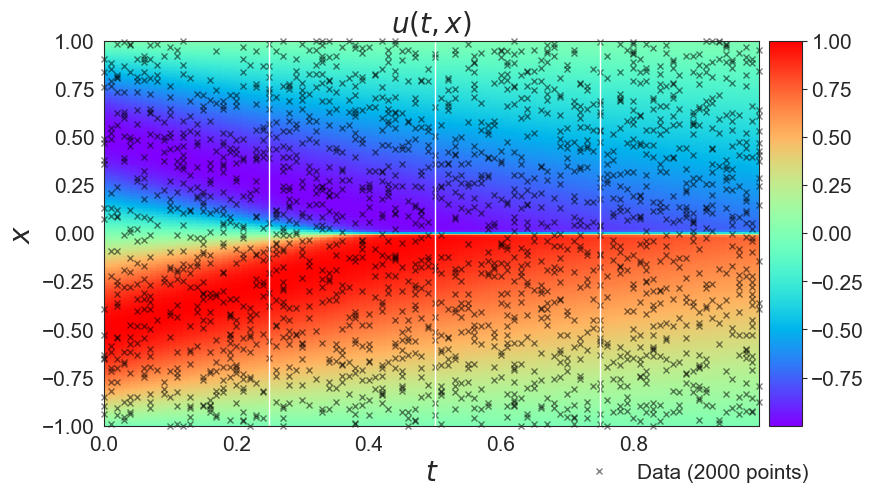

In [11]:
####### Row 0: u(t,x) ##################    

fig = plt.figure(figsize=(9, 5))
ax = fig.add_subplot(111)

h = ax.imshow(U_pred.T, interpolation='nearest', cmap='rainbow', 
              extent=[t.min(), t.max(), x.min(), x.max()], 
              origin='lower', aspect='auto')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.10)
cbar = fig.colorbar(h, cax=cax)
cbar.ax.tick_params(labelsize=15) 

ax.plot(
    X_u_train[:,1], 
    X_u_train[:,0], 
    'kx', label = 'Data (%d points)' % (u_train.shape[0]), 
    markersize = 4,  # marker size doubled
    clip_on = False,
    alpha=.5
)

line = np.linspace(x.min(), x.max(), 2)[:,None]
ax.plot(t[25]*np.ones((2,1)), line, 'w-', linewidth = 1)
ax.plot(t[50]*np.ones((2,1)), line, 'w-', linewidth = 1)
ax.plot(t[75]*np.ones((2,1)), line, 'w-', linewidth = 1)

ax.set_xlabel('$t$', size=20)
ax.set_ylabel('$x$', size=20)
ax.legend(
    loc='upper center', 
    bbox_to_anchor=(0.9, -0.05), 
    ncol=5, 
    frameon=False, 
    prop={'size': 15}
)
ax.set_title('$u(t,x)$', fontsize = 20) # font size doubled
ax.tick_params(labelsize=15)

plt.show()

C:\Users\ameyv\AppData\Local\Temp\ipykernel_19976\1452404817.py:9: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(gs1[0, 0])


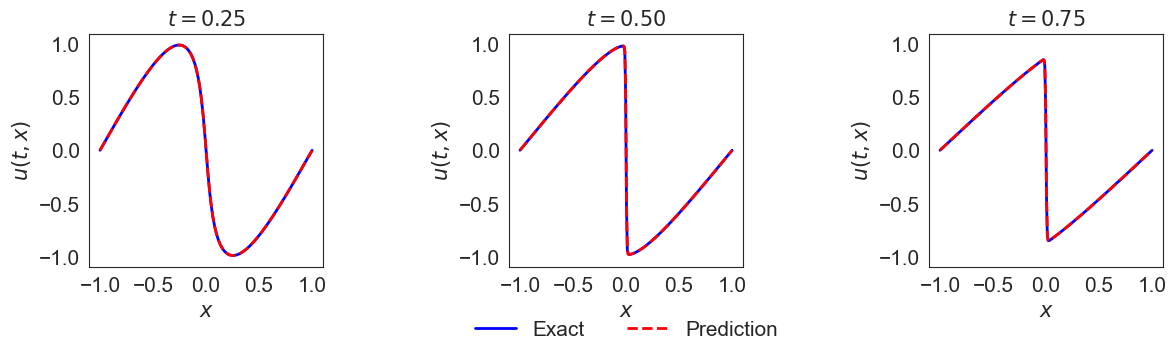

In [12]:
####### Row 1: u(t,x) slices ################## 

fig = plt.figure(figsize=(14, 10))
ax = fig.add_subplot(111)

gs1 = gridspec.GridSpec(1, 3)
gs1.update(top=1-1.0/3.0-0.1, bottom=1.0-2.0/3.0, left=0.1, right=0.9, wspace=0.5)

ax = plt.subplot(gs1[0, 0])
ax.plot(x,Exact[25,:], 'b-', linewidth = 2, label = 'Exact')       
ax.plot(x,U_pred[25,:], 'r--', linewidth = 2, label = 'Prediction')
ax.set_xlabel('$x$')
ax.set_ylabel('$u(t,x)$')    
ax.set_title('$t = 0.25$', fontsize = 15)
ax.axis('square')
ax.set_xlim([-1.1,1.1])
ax.set_ylim([-1.1,1.1])

for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(15)

ax = plt.subplot(gs1[0, 1])
ax.plot(x,Exact[50,:], 'b-', linewidth = 2, label = 'Exact')       
ax.plot(x,U_pred[50,:], 'r--', linewidth = 2, label = 'Prediction')
ax.set_xlabel('$x$')
ax.set_ylabel('$u(t,x)$')
ax.axis('square')
ax.set_xlim([-1.1,1.1])
ax.set_ylim([-1.1,1.1])
ax.set_title('$t = 0.50$', fontsize = 15)
ax.legend(
    loc='upper center', 
    bbox_to_anchor=(0.5, -0.15), 
    ncol=5, 
    frameon=False, 
    prop={'size': 15}
)

for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(15)

ax = plt.subplot(gs1[0, 2])
ax.plot(x,Exact[75,:], 'b-', linewidth = 2, label = 'Exact')       
ax.plot(x,U_pred[75,:], 'r--', linewidth = 2, label = 'Prediction')
ax.set_xlabel('$x$')
ax.set_ylabel('$u(t,x)$')
ax.axis('square')
ax.set_xlim([-1.1,1.1])
ax.set_ylim([-1.1,1.1])    
ax.set_title('$t = 0.75$', fontsize = 15)

for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(15)

plt.show()

In [13]:
# evaluations
u_pred, f_pred = model.predict(X_star)

lambda_1_value_noisy = model.lambda_1.detach().cpu().numpy()
lambda_2_value_noisy = model.lambda_2.detach().cpu().numpy()
lambda_2_value_noisy = np.exp(lambda_2_value_noisy)

# Percentage Error
error_lambda_1_noisy = np.abs(lambda_1_value_noisy - 1.0) * 100
error_lambda_2_noisy = np.abs(lambda_2_value_noisy - nu) / nu * 100

print('Relative L2 Error u: %e' % (error_u))    
print('Percentage Error l1: %.5f%%' % (error_lambda_1_noisy))                             
print('Percentage Error l2: %.5f%%' % (error_lambda_2_noisy))  

Error u: 1.965859e-03
Error l1: 0.28633%
Error l2: 0.72968%


In [15]:
import matplotlib as mpl
mpl.rcParams['text.usetex'] = True
mpl.rcParams['text.latex.preamble'] = [r'\usepackage{amsmath}']

C:\Users\ameyv\AppData\Local\Temp\ipykernel_19976\3040959772.py:3: MatplotlibDeprecationWarning: Support for setting an rcParam that expects a str value to a non-str value is deprecated since 3.5 and support will be removed two minor releases later.
  mpl.rcParams['text.latex.preamble'] = [r'\usepackage{amsmath}']


In [20]:
####### Row 3: Identified PDE ##################    

s1 = "Correct PDE: du_dt + du*du_dx - 0.0031831*du_dxx = 0 \n"
s2 = "Noiseless discovered PDE: du_dt + %.7f*du*du_dx - %.7f*du_dxx = 0 \n" % (lambda_1_value, lambda_2_value)
s3 = "Noiseless discovered PDE: du_dt + %.7f*du*du_dx - %.7f*du_dxx = 0 \n" % (lambda_1_value_noisy, lambda_2_value_noisy)

print(s1)
print(s2)
print(s3)

Correct PDE: du_dt + du*du_dx - 0.0031831*du_dxx = 0 

Noiseless discovered PDE: du_dt + 0.9996753*du*du_dx - 0.0032152*du_dxx = 0 

Noiseless discovered PDE: du_dt + 0.9971367*du*du_dx - 0.0031599*du_dxx = 0 

